In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

## Introduction

Here are some possible business questions:

- What factors contribute most heavily to the price? 
    - Make a model to predict the price - one that's interpretable and perhaps one (like a neural network) that's not interpretable but does a better job of price prediction.
    - Which listings are underpriced, meaning that the host could make more money by increasing the price, or travelers can get a good deal by booking them?
    - Perhaps extend beyond predicting only base prices to predicting prices at different times of year.
- What should those listings with poor overall review scores do in order to get better reviews in the future?
- What can we discern about the character of each neighborhood using the descriptions?

In [2]:
listings = pd.read_csv("listings.csv")
calendar = pd.read_csv("calendar.csv")

Definitions for many (though not all) of the fields can be found [here](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896).

Drop columns that have all `NA` values.

In [3]:
for df in [listings, calendar]:
    df.dropna(axis=1, how='all', inplace=True)

Drop rows in `listings` that have `NA` in the `price` field, and do the same for the `price` and `adjusted_price` fields in `calendar`.

In [4]:
listings.dropna(subset=['price'], inplace=True)
calendar.dropna(subset=['price', 'adjusted_price'], inplace=True)

Observe that a dollar sign preceeds the number in several columns; I will remove this so that the field is treated as numeric.

In [5]:
listings['price'] = listings.apply((lambda x: x['price'].replace('$','').replace(',','')), axis=1)
calendar['price'] = calendar.apply((lambda x: x['price'].replace('$','').replace(',','')), axis=1)
calendar['adjusted_price'] = calendar.apply((lambda x: x['adjusted_price'].replace('$','').replace(',','')), axis=1)

The price should be greater than zero. I'll drop all rows where this is not the case.

In [6]:
listings['price'] = listings['price'].astype(np.float64)
calendar['price'] = calendar['price'].astype(np.float64)
calendar['adjusted_price'] = calendar['adjusted_price'].astype(np.float64)

In [7]:
listings.drop(listings.loc[listings['price'] <= 0].index, inplace=True)

Similarly, some of the fields are expressed as percentages; I will remove the percent signs and change the entries to floats.

In [8]:
listings['host_response_rate'] = listings.apply(lambda x: float(x['host_response_rate'].replace('%','')) if pd.notnull(x['host_response_rate']) else x['host_response_rate'], axis=1)
listings['host_acceptance_rate'] = listings.apply(lambda x: float(x['host_acceptance_rate'].replace('%','')) if pd.notnull(x['host_acceptance_rate']) else x['host_acceptance_rate'], axis=1)

# 1. Price prediction

## Data preparation

Split into `X` and `y`.

In [9]:
X = listings.drop('price', axis=1)
y = listings['price']

I also need to deal with dates appropriately. The relevant columns are `host_since`, `first_review`, and `last_review`. I could scrap these columns altogether, but it might be useful to know the length of time since the date for each row. 

In [10]:
for col in ['host_since', 'first_review', 'last_review']:
    X[col] = pd.to_datetime(X['last_scraped']) - pd.to_datetime(X[col])
    X[col] = X.apply(lambda x: x[col].days, axis=1)

Certain columns in `X` are not useful for prediction (for example, URLs), and should be removed.

In [11]:
to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name']
to_drop += ['description', 'neighborhood_overview', 'picture_url', 'host_id']
to_drop += ['host_url', 'host_name', 'host_about', 'host_thumbnail_url']
to_drop += ['host_picture_url', 'license', 'calendar_last_scraped']
X.drop(labels=to_drop, axis=1, inplace=True)

Certain columns (`host_verifications` and `amenities`) are lists of options; I'd like to split these into different columns.

The first step is to change these entries into actual Python lists instead of strings (annoyingly, the two relevant columns are formatted slightly differently, with the roles of single and double quotes being interchanged between them).

In [12]:
X['host_verifications'] = X.apply(lambda x: x['host_verifications'].replace('[','').replace(']','').replace('\'','').split(', '), axis=1)

In [13]:
X['amenities'] = X.apply(lambda x: x['amenities'].replace('\"','').replace('[','').replace(']','').split(', '), axis=1)

What are the possible values in the `host_verifications` lists?

In [14]:
distinct_host_verifications = set()
def find_distinct_hvs(x):
    for hv in x['host_verifications']:
        distinct_host_verifications.add(hv)
X.apply(lambda x: find_distinct_hvs(x), axis=1);

In [15]:
len(distinct_host_verifications)

20

The `MultiLabelBinarizer` in `sklearn` works for splitting the lists into their individual elements, and then creating a dummy variable for each one (I started to write this myself, and then found that this convenient function exists in sklearn!).

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

In [17]:
m = MultiLabelBinarizer()
hv_df = pd.DataFrame(m.fit_transform(X['host_verifications']), columns=m.classes_, index=X.index)

In [18]:
X = pd.concat([X, hv_df], axis=1)

In [19]:
X.rename(columns={'None' : 'HV_None'}, inplace=True)
# I don't want a column to be called just 'None', so I changed it a bit

Now I can drop the original `host_verifications` column.

In [20]:
X.drop('host_verifications', axis=1, inplace=True)

Now I'd like to do the same for the `amenities` column. What are the possible values in those lists?

In [21]:
distinct_amenities = set()
def find_distinct_amenities(x):
    for a in x['amenities']:
        distinct_amenities.add(a)
X.apply(lambda x: find_distinct_amenities(x), axis=1)
len(distinct_amenities)

976

Ok, that's a lot of amenities. I don't really want to vastly blow up the number of features like this, so I'll just take the 20 most popular amenities.

In [22]:
from collections import defaultdict
from operator import itemgetter

In [23]:
amenity_counts = defaultdict(int) # Initializes to zero for each value
def update_counts(x):
    for a in x['amenities']:
        amenity_counts[a] += 1
X.apply(lambda x: update_counts(x), axis=1);

In [24]:
top_20 = sorted(amenity_counts.items(), key=itemgetter(1), reverse=True)[:20]

In [25]:
top_20[:5]

[('Smoke alarm', 6357),
 ('Essentials', 6185),
 ('Wifi', 6141),
 ('Kitchen', 5930),
 ('Carbon monoxide alarm', 5924)]

In [26]:
top_20_amenities = dict(top_20).keys()

Now I want to get rid of the other amenities in each row.

In [27]:
def find_amenities(x):
    amenities = []
    for a in top_20_amenities:
        if a in x['amenities']:
            amenities.append(a)
    return amenities

In [28]:
X['amenities'] = X.apply(lambda x: find_amenities(x), axis=1)

Now I can create the dummy variables and drop the original `amenities` column.

In [29]:
m = MultiLabelBinarizer()
amenities_df = pd.DataFrame(m.fit_transform(X['amenities']), columns=m.classes_, index=X.index)
X = pd.concat([X, amenities_df], axis=1)
X.drop('amenities', axis=1, inplace=True)

Next, I'll get dummies for the rest of the categorical variables.

In [30]:
X = pd.get_dummies(X, drop_first=True)

I need to deal with `NA` values for the numeric columns. There's no totally ideal way to do this, but to move forward I'll impute using the mean.

In [31]:
fill_mean = lambda col: col.fillna(col.mean())
X = X.apply(fill_mean)

## Modeling and Evaluation

Split into train and test sets.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Now, don't touch the test set until the end (use cross-validation to evaluate models before then). I don't want to bias myself by picking up patterns in the test set.

It will be useful for me to have a validation set (e.g. for plotting results to get a handle on what's going on) that I can access explicitly, instead of just the ones that `cross_val_score` uses in the course of its execution.

In [33]:
X_val_train, X_val, y_val_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

### Linear Model

Instantiate the model, including normalization in the pipeline:

In [34]:
pipe = make_pipeline(StandardScaler(), LinearRegression())

In [35]:
scores = cross_val_score(pipe, X, y)
print("Scores:")
print(scores)
print(f"Mean = {scores.mean():.3g}, Standard Error = {scores.std()/np.sqrt(5):.3g}")

Scores:
[-7.40014071e+27 -4.95586292e+24 -9.25731042e+25 -1.48315083e+28
 -1.14712826e+29]
Mean = -2.74e+28, Standard Error = 1.97e+28


Score the model on the validation set:

In [36]:
pipe.fit(X_val_train, y_val_train)
pipe.score(X_val, y_val)

-4.154608976954608e+27

In [37]:
y_pred = pipe.predict(X_val)

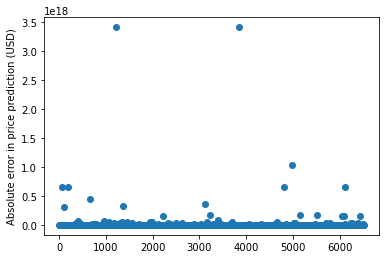

In [38]:
plt.plot(np.abs(y_val - y_pred), 'o')
plt.ylabel('Absolute error in price prediction (USD)')
plt.show()

Clearly some of the predictions are enormous and completely unreasonable. I think I need to aggressively get rid of features to correct this - I have way too many irrelevant categorical variables.

In [129]:
def fit_model(X, y, model, cutoff=False, return_X_cutoff=False):
    pipe = make_pipeline(StandardScaler(), model)
    if cutoff is False:
        cutoff = -1
    # Only keep features for which the average absolute value
    # over all samples exceeds some cutoff
    to_keep = np.where(np.abs(X.sum()/len(X)) > cutoff)[0]
    X_cutoff = X.iloc[:, to_keep]
    y_pred = cross_val_predict(pipe, X_cutoff, y)
    #pipe.fit(X_cutoff, y)
    if return_X_cutoff:
        return y_pred, X_cutoff
    else:
        return y_pred

In [40]:
def score_model(X, y, model, cutoff, return_n_features=False, random_state=42, scoring=None):
    pipe = make_pipeline(StandardScaler(), model)
    X_cutoff = X.iloc[:, np.where(np.abs(X.sum()/len(X)) > cutoff)[0]]
    scores = cross_val_score(pipe, X_cutoff, y, scoring=scoring)
    if return_n_features:
        return scores, X_cutoff.shape[1]
    else:
        return scores

In [41]:
def test_cutoffs(X, y, model, cutoffs, scoring=None):
    results = {}
    for cutoff in cutoffs:
        scores, n_features = score_model(X, y, model, cutoff, return_n_features=True, scoring=scoring)
        print(f"Cutoff = {cutoff:.3g}, Mean score = {scores.mean():.3g}, Standard error = {scores.std()/np.sqrt(5):.3g}, n_features = {n_features}")
    return scores

In [42]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs);

Cutoff = 1e+03, Mean score = -0.0687, Standard error = 0.0629, n_features = 4
Cutoff = 1, Mean score = -0.726, Standard error = 0.702, n_features = 38
Cutoff = 0.9, Mean score = -1.44, Standard error = 1.45, n_features = 47
Cutoff = 0.7, Mean score = -2.14, Standard error = 2.16, n_features = 62
Cutoff = 0.3, Mean score = -2.17, Standard error = 2.19, n_features = 76
Cutoff = 0.1, Mean score = -2.31, Standard error = 2.34, n_features = 86
Cutoff = 0.05, Mean score = -2.33, Standard error = 2.37, n_features = 100
Cutoff = 0.01, Mean score = -2.72, Standard error = 2.75, n_features = 165
Cutoff = 0.005, Mean score = -2.69, Standard error = 2.72, n_features = 200
Cutoff = 0.003, Mean score = -2.77, Standard error = 2.8, n_features = 231
Cutoff = 0.001, Mean score = -3.5e+26, Standard error = 3.1e+26, n_features = 299
Cutoff = 0, Mean score = -1.65e+27, Standard error = 1.1e+27, n_features = 659


Many of these CV scores are horrific; none of the models have better coefficient of determination than a model that just predicts the mean price every time. And there's another problem: many of the predicted prices are negative!

In [130]:
y_pred_L = fit_model(X_train, y_train, LinearRegression(), 0.01)

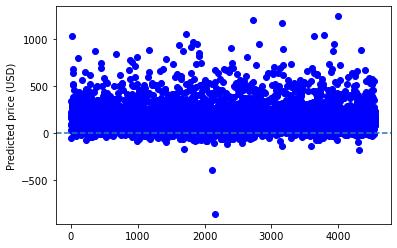

In [131]:
plt.plot(y_pred_L, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

Thinking about what I actually want from my model, I don't care so much if there are a few outliers for which price predictions are very poor. I'm more concerned with the *median* absolute fractional error, not the *mean* absolute error. I'll express this as a percent.

In [132]:
def median_abs_pct_err(y_true, y_pred):
    return 100*np.abs((y_true - y_pred)/y_true).median()

In [134]:
median_abs_pct_err(y_train, y_pred_L)

38.54746880950186

Still quite awful: half of the predictions are off by over 400%.

In [47]:
median_scorer = make_scorer(median_abs_pct_err)

In [48]:
def df_pct_abs_err(y_pred, y_true, plot=False, plot_cutoff=300):
    df = pd.DataFrame(100*np.abs((y_true - y_pred)/y_true))
    df = df.rename(columns={'price':'pct_abs_err'})
    if plot:
        df[df['pct_abs_err'] < plot_cutoff].hist()
        plt.ylabel("Number of occurrences")
        plt.xlabel("Absolute error in price prediction (%)")
        plt.title
        plt.show()
    return df

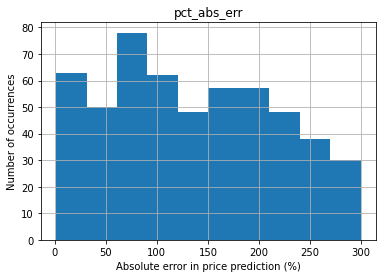

433.50088690773737

In [49]:
df_pct_abs_err(y_pred_L, y_train, plot=True).median().item()

In [50]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 147, Standard error = 10.1, n_features = 4
Cutoff = 1, Mean score = 314, Standard error = 24.7, n_features = 38
Cutoff = 0.9, Mean score = 311, Standard error = 15.6, n_features = 47
Cutoff = 0.7, Mean score = 410, Standard error = 23.4, n_features = 62
Cutoff = 0.3, Mean score = 426, Standard error = 21.3, n_features = 76
Cutoff = 0.1, Mean score = 461, Standard error = 29.1, n_features = 86
Cutoff = 0.05, Mean score = 457, Standard error = 33.1, n_features = 100
Cutoff = 0.01, Mean score = 472, Standard error = 26, n_features = 165
Cutoff = 0.005, Mean score = 481, Standard error = 24.9, n_features = 200
Cutoff = 0.003, Mean score = 483, Standard error = 25.2, n_features = 231
Cutoff = 0.001, Mean score = 508, Standard error = 24.2, n_features = 299
Cutoff = 0, Mean score = 629, Standard error = 37, n_features = 659


These mean scores are the mean of the median absolute percentage error, computed across the five cross-validation folds.

### Dealing with outliers

If a listing has an absurdly high price that isn't reflective of what people will actually pay, or just isn't that relevant for a typical person who wants to list their place, that isn't good for the usefulness of our model. Models that are trained using $L^2$ loss, including `LinearRegression()`, penalize outliers (in the target variable) very sharply, which can be problematic for training (i.e. mimizing the mean-squared loss). Therefore, I'll take a look at places that have extremely high prices and see if it makes sense to remove them.

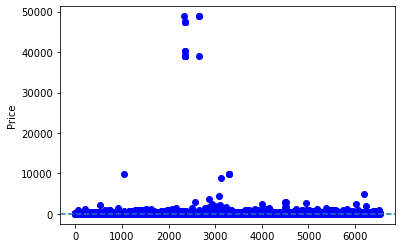

In [51]:
plt.plot(listings['price'], 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel("Price")
plt.show()

Yeah, some of these prices look like they might be absurd.

In [52]:
listings['price'].sort_values(ascending=False).head(30)

2648    48864.0
2647    48864.0
2341    48864.0
2360    47484.0
2361    47484.0
2359    47484.0
2362    47484.0
2346    40356.0
2345    40356.0
2350    39132.0
2355    39132.0
2351    39132.0
2356    39132.0
2353    39132.0
2650    39132.0
2354    39132.0
2352    39132.0
2358    39132.0
2357    39132.0
3288     9999.0
1049     9999.0
3287     9999.0
3289     9999.0
3120     9000.0
6196     5000.0
3072     4500.0
2866     3690.0
4522     3070.0
4498     3042.0
2570     3000.0
Name: price, dtype: float64

In [53]:
# Find the URL of one of the most expensive places
listings.loc[2648, 'listing_url']

'https://www.airbnb.com/rooms/30718928'

What is going on here? Following the link above, this is clearly a luxury place, but it's just a studio! On top of that, it's currently listed at USD 1,653 per night (as of December 3, 2021), not USD 48,864 per night as above. Let's take a closer look at `calendar` to see what happened:

In [54]:
listing_id = listings.loc[2648, 'id']

In [55]:
calendar.loc[calendar['listing_id']==listing_id, ['date', 'price', 'adjusted_price']]

,date,price,adjusted_price
1020296,2021-10-18,8144.0,48864.0
1020297,2021-10-19,8144.0,48864.0
1020298,2021-10-20,8144.0,48864.0
1020299,2021-10-21,8144.0,48864.0
1020300,2021-10-22,8144.0,48864.0
...,...,...,...
1023099,2022-10-13,263.0,1578.0
1023100,2022-10-14,307.0,1842.0
1023101,2022-10-15,307.0,1842.0
1023102,2022-10-16,263.0,1578.0


OK, it appears that the adjusted price was very high in mid-October, and that's what was pulled into the `price` field in `listings`. My understanding is that Airbnb allows hosts to turn on a setting that automatically adjusts the price according to demand (using some model developed by Airbnb), so likely demand was extremely high at nearby properties at that time. In any case, it would make sense for me to exclude this property and related ones from my data; I note that each of the properties over USD 10,000 are in the "Ginosi 747 Apartel", as can be easily verified by clicking on those URLs. Further, one of the next most expensive listings, at USD 9,999, is a 12-bedroom mansion.

Now I'll delete these outliers (those listings with prices above USD 10,000 per night). It makes sense to do this across all the data (not just for the training data), since I'm not interested in making predictions for places where the price would be that high (totally out of whack with what almost everyone would pay - prices that would actually banned by law for similar hotel accommodations), and I'd like to use all the data to create my final model.

In [56]:
to_drop = y[y > 10000].index

In [57]:
# Drop the necessary rows
X.drop(to_drop, inplace=True)
y.drop(to_drop, inplace=True)
# Drop the rows from the original dataframe as well (since I'll use this dataframe
# again shortly)
listings.drop(to_drop, inplace=True)

In [59]:
# Do the train-test splits again
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_val_train, X_val, y_val_train, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42)

### Linear Model, Again

In [60]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs);

Cutoff = 1e+03, Mean score = -0.00261, Standard error = 0.00357, n_features = 4
Cutoff = 1, Mean score = 0.354, Standard error = 0.0511, n_features = 38
Cutoff = 0.9, Mean score = 0.356, Standard error = 0.0494, n_features = 47
Cutoff = 0.7, Mean score = 0.354, Standard error = 0.0487, n_features = 62
Cutoff = 0.3, Mean score = 0.359, Standard error = 0.0486, n_features = 76
Cutoff = 0.1, Mean score = 0.379, Standard error = 0.0494, n_features = 87
Cutoff = 0.05, Mean score = 0.383, Standard error = 0.0496, n_features = 99
Cutoff = 0.01, Mean score = 0.396, Standard error = 0.053, n_features = 166
Cutoff = 0.005, Mean score = 0.405, Standard error = 0.0541, n_features = 205
Cutoff = 0.003, Mean score = 0.397, Standard error = 0.0518, n_features = 232
Cutoff = 0.001, Mean score = -4.89e+24, Standard error = 3.66e+24, n_features = 304
Cutoff = 0, Mean score = -2.86e+26, Standard error = 1.15e+26, n_features = 654


In [61]:
cutoffs = [1000, 1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0]
test_cutoffs(X_train, y_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 58.9, Standard error = 1.71, n_features = 4
Cutoff = 1, Mean score = 41, Standard error = 1.25, n_features = 38
Cutoff = 0.9, Mean score = 41.1, Standard error = 1.22, n_features = 47
Cutoff = 0.7, Mean score = 42.3, Standard error = 1.09, n_features = 62
Cutoff = 0.3, Mean score = 41.4, Standard error = 1.09, n_features = 76
Cutoff = 0.1, Mean score = 41.2, Standard error = 0.947, n_features = 87
Cutoff = 0.05, Mean score = 41.6, Standard error = 1.02, n_features = 99
Cutoff = 0.01, Mean score = 38.8, Standard error = 0.908, n_features = 166
Cutoff = 0.005, Mean score = 39.5, Standard error = 0.583, n_features = 205
Cutoff = 0.003, Mean score = 38.9, Standard error = 1.11, n_features = 232
Cutoff = 0.001, Mean score = 37.7, Standard error = 0.865, n_features = 304
Cutoff = 0, Mean score = 40.4, Standard error = 0.64, n_features = 654


In [62]:
y_pred_L = fit_model(X_train, y_train, LinearRegression(), cutoff=0.005)

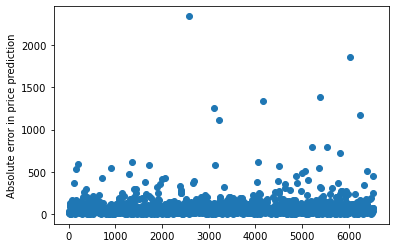

In [63]:
plt.plot(np.abs(y_train - y_pred_L), 'o')
plt.ylabel('Absolute error in price prediction')
plt.show()

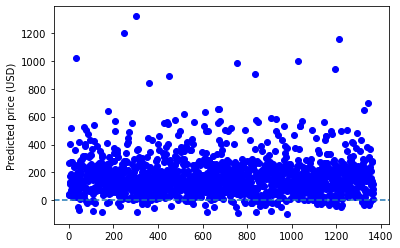

In [64]:
plt.plot(y_pred_L, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

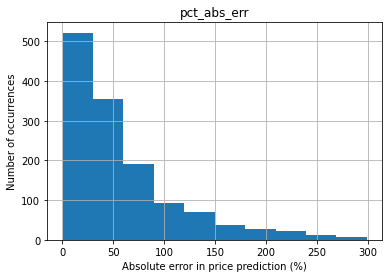

In [65]:
df_err_L = df_pct_abs_err(y_pred_L, y_train, plot=True)

In [61]:
df_err_L['pct_abs_err'].median()

40.92486406832323

That is, 50% of predictions are off from the true price by less than 41%.

This is certainly better than the previous model, though still not great, and a fair number of the predictions are still negative.

### Smaller Linear Model

What happens if I just use a smaller model? Maybe the one above is too big and has a lot of unnecessary features, even using cutoffs as above. What do we expect to be the most useful factors for price prediction? My guesses for the most important: Its size (number of people, number of bedrooms and bathrooms) and the neighborhood. The relevant columns are `neighbourhood_cleansed`, `accommodates`, `bathrooms_text`, `bedrooms`, and `beds`.

In [66]:
X_small = listings[['neighbourhood_cleansed','accommodates','bathrooms_text','bedrooms','beds']]

In [67]:
X_small = pd.get_dummies(X_small, drop_first=True)

In [68]:
y_small = y.copy()

I need to deal with the `NA` entries in `beds` and `bedrooms`.

In [69]:
X_small['bedrooms'] = X_small.apply(lambda x: x['beds'] if not(x['bedrooms']>0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['bedrooms'] if not(x['beds']>0) else x['beds'], axis=1)

In [70]:
sum(X_small.isna()['beds'])

4

In [71]:
X_small.loc[X_small.isna()['bedrooms']]

,accommodates,bedrooms,beds,neighbourhood_cleansed_Archer Heights,neighbourhood_cleansed_Armour Square,neighbourhood_cleansed_Ashburn,neighbourhood_cleansed_Auburn Gresham,neighbourhood_cleansed_Austin,neighbourhood_cleansed_Avalon Park,neighbourhood_cleansed_Avondale,...,bathrooms_text_5 baths,bathrooms_text_5.5 baths,bathrooms_text_6 baths,bathrooms_text_6.5 baths,bathrooms_text_7 baths,bathrooms_text_7.5 baths,bathrooms_text_8 shared baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath
5590,2,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6015,4,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6416,2,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6516,4,NaN,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
to_drop = X_small.loc[X_small['accommodates'] == 0].index
X_small.drop(to_drop, inplace=True)
y_small.drop(to_drop, inplace=True)

In [73]:
X_small['bedrooms'] = X_small.apply(lambda x: x['accommodates'] if not(x['bedrooms'] > 0) else x['bedrooms'], axis=1)
X_small['beds'] = X_small.apply(lambda x: x['accommodates'] if not(x['beds'] > 0) else x['beds'], axis=1)

In [74]:
sum(X_small.isna()['bedrooms'])

0

In [75]:
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(
    X_small, y_small, test_size=0.3, random_state=42)
X_small_val_train, X_small_val, y_small_val_train, y_small_val = train_test_split(
    X_small_train, y_small_train, test_size=0.3, random_state=42)

In [76]:
cutoffs = [1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0.0005, 0]
test_cutoffs(X_small_train, y_small_train, LinearRegression(), cutoffs);

Cutoff = 1, Mean score = 0.311, Standard error = 0.0444, n_features = 3
Cutoff = 0.9, Mean score = 0.311, Standard error = 0.0444, n_features = 3
Cutoff = 0.7, Mean score = 0.311, Standard error = 0.0444, n_features = 3
Cutoff = 0.3, Mean score = 0.312, Standard error = 0.0444, n_features = 4
Cutoff = 0.1, Mean score = 0.342, Standard error = 0.0462, n_features = 8
Cutoff = 0.05, Mean score = 0.359, Standard error = 0.0475, n_features = 13
Cutoff = 0.01, Mean score = 0.376, Standard error = 0.047, n_features = 39
Cutoff = 0.005, Mean score = 0.379, Standard error = 0.0488, n_features = 48
Cutoff = 0.003, Mean score = 0.384, Standard error = 0.0471, n_features = 61
Cutoff = 0.001, Mean score = 0.395, Standard error = 0.0501, n_features = 79
Cutoff = 0.0005, Mean score = 0.395, Standard error = 0.0507, n_features = 86
Cutoff = 0, Mean score = -1.21e+22, Standard error = 1.05e+22, n_features = 103


In [79]:
cutoffs = [1, .9, .7, .3, .1, .05, .01, 0.005, 0.003, 0.001, 0.0005, 0]
test_cutoffs(X_small_train, y_small_train, LinearRegression(), cutoffs, scoring=median_scorer);

Cutoff = 1, Mean score = 43.4, Standard error = 0.73, n_features = 3
Cutoff = 0.9, Mean score = 43.4, Standard error = 0.73, n_features = 3
Cutoff = 0.7, Mean score = 43.4, Standard error = 0.73, n_features = 3
Cutoff = 0.3, Mean score = 45.2, Standard error = 0.711, n_features = 4
Cutoff = 0.1, Mean score = 42.8, Standard error = 1.34, n_features = 8
Cutoff = 0.05, Mean score = 42, Standard error = 1.01, n_features = 13
Cutoff = 0.01, Mean score = 38, Standard error = 0.614, n_features = 39
Cutoff = 0.005, Mean score = 37.6, Standard error = 0.83, n_features = 48
Cutoff = 0.003, Mean score = 36.6, Standard error = 1.06, n_features = 61
Cutoff = 0.001, Mean score = 34.9, Standard error = 1.08, n_features = 79
Cutoff = 0.0005, Mean score = 34.8, Standard error = 1.1, n_features = 86
Cutoff = 0, Mean score = 34, Standard error = 0.751, n_features = 103


Not bad! It looks like I guessed some of the most important factors correctly.

In [77]:
y_pred_small = fit_model(X_small_train, y_small_train, LinearRegression(), cutoff=0.0005)

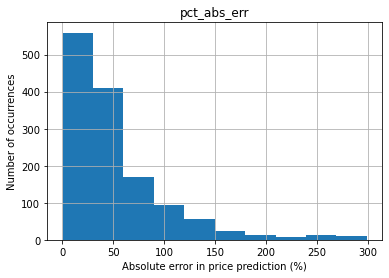

38.16947366374975

In [78]:
df_pct_abs_err(y_pred_small, y_train_small, plot=True).median().item()

The median absolute error is slightly smaller than for my previous model.

Still, there is a long way to go to get predictions I'd consider good enough.

### Elastic Net

There are more sophisticated models that help me get rid of irrelevent features by setting their weights to zero in the model. I'll use sklearn's `ElasticNet`, which has this favorable Lasso property while also having the L2 regularization properties of ridge regression.

In [80]:
from sklearn.linear_model import ElasticNet

In [81]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, ElasticNet(), cutoffs);

Cutoff = 1e+03, Mean score = -0.00344, Standard error = 0.00336, n_features = 4
Cutoff = 1, Mean score = 0.349, Standard error = 0.0496, n_features = 38
Cutoff = 0.99, Mean score = 0.348, Standard error = 0.0496, n_features = 40
Cutoff = 0.5, Mean score = 0.356, Standard error = 0.0483, n_features = 70
Cutoff = 0.3, Mean score = 0.357, Standard error = 0.0485, n_features = 76
Cutoff = 0.2, Mean score = 0.359, Standard error = 0.049, n_features = 79
Cutoff = 0.1, Mean score = 0.375, Standard error = 0.0506, n_features = 87
Cutoff = 0.05, Mean score = 0.382, Standard error = 0.0497, n_features = 99
Cutoff = 0.01, Mean score = 0.392, Standard error = 0.0526, n_features = 166
Cutoff = 0.005, Mean score = 0.397, Standard error = 0.0519, n_features = 205
Cutoff = 0.002, Mean score = 0.399, Standard error = 0.0521, n_features = 246
Cutoff = 0.001, Mean score = 0.429, Standard error = 0.055, n_features = 304
Cutoff = 0.0005, Mean score = 0.428, Standard error = 0.0534, n_features = 361
Cutoff 

In [82]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, ElasticNet(), cutoffs, scoring=median_scorer);

Cutoff = 1e+03, Mean score = 59.2, Standard error = 1.72, n_features = 4
Cutoff = 1, Mean score = 38.6, Standard error = 0.807, n_features = 38
Cutoff = 0.99, Mean score = 38.6, Standard error = 0.809, n_features = 40
Cutoff = 0.5, Mean score = 38.7, Standard error = 1.05, n_features = 70
Cutoff = 0.3, Mean score = 38.6, Standard error = 1.22, n_features = 76
Cutoff = 0.2, Mean score = 38.1, Standard error = 1.24, n_features = 79
Cutoff = 0.1, Mean score = 36.9, Standard error = 1.06, n_features = 87
Cutoff = 0.05, Mean score = 35.4, Standard error = 0.813, n_features = 99
Cutoff = 0.01, Mean score = 34.1, Standard error = 0.85, n_features = 166
Cutoff = 0.005, Mean score = 34.2, Standard error = 0.756, n_features = 205
Cutoff = 0.002, Mean score = 33.7, Standard error = 0.722, n_features = 246
Cutoff = 0.001, Mean score = 32.9, Standard error = 0.523, n_features = 304
Cutoff = 0.0005, Mean score = 32.9, Standard error = 0.455, n_features = 361
Cutoff = 0, Mean score = 32.2, Standard e

In [83]:
y_pred_E = fit_model(X_train, y_train, ElasticNet(), cutoff=0)

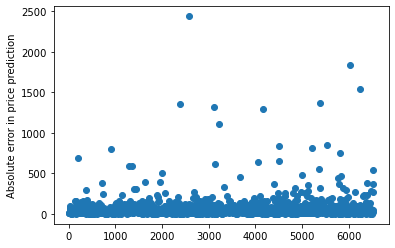

In [84]:
plt.plot(np.abs(y_train - y_pred_E), 'o')
plt.ylabel('Absolute error in price prediction')
plt.show()

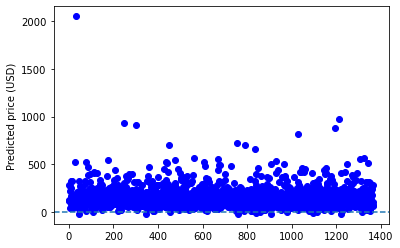

In [85]:
plt.plot(y_pred_E, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

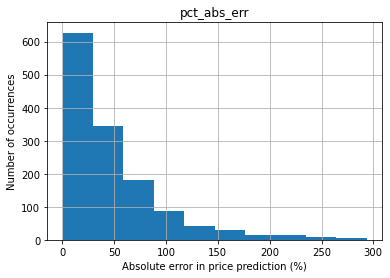

In [86]:
df_err_E = df_pct_abs_err(y_pred_E, y_train, plot=True)

In [87]:
df_err_E.median().item()

33.586582407989596

The CV score (mean $R^2$ between folds) and the median absolute error have both improved, though not substantially.

What are the most important features? For these results to be robust, I average the coefficients over the five folds obtained during cross-validation.

In [119]:
cv_dict = cross_validate(pipe, X_train, y_train, return_estimator=True)
estimators = cv_dict['estimator']
coeffs = np.zeros(X_train.shape[1])
for i in range(5):
    coeffs += estimators[i].named_steps['elasticnet'].coef_
coeffs /= 5

In [120]:
df = pd.DataFrame(np.array([X_train.columns, coeffs, np.abs(coeffs)]).T, columns=['feature','coeff', 'abs_coeff'])
df = df.sort_values(by='abs_coeff', ascending=False)
df.head(30)

,feature,coeff,abs_coeff
730,bathrooms_text_6 baths,28.378552,28.378552
7,accommodates,23.88561,23.88561
8,bedrooms,23.043712,23.043712
9,beds,20.843689,20.843689
714,bathrooms_text_10 baths,19.09428,19.09428
731,bathrooms_text_6.5 baths,15.865909,15.865909
724,bathrooms_text_3.5 baths,13.909972,13.909972
732,bathrooms_text_7 baths,13.229963,13.229963
727,bathrooms_text_4.5 baths,12.740377,12.740377
469,host_neighbourhood_Lake View,12.408811,12.408811


Interestingly, the top 20 features or so all have positive coefficients, except for one (the "only one bathroom" feature). The larger the values of those features are, the larger we expect the price to be.

Note that ElasticNet eliminates some features by setting their coefficients to zero.

In [121]:
len(df.loc[df['abs_coeff']==0])

159

In [122]:
X_E = X.drop(list(df.loc[df['abs_coeff']==0, 'feature']), axis=1)

In [123]:
X_E_train, X_E_test, y_E_train, y_E_test = train_test_split(
    X_E, y, test_size=0.3, random_state=42)
X_E_val_train, X_E_val, y_E_val_train, y_E_val = train_test_split(
    X_E_train, y_E_train, test_size=0.3, random_state=42)

I'd like to build some more accurate models, even if they are less interpretable. Things to try:

- k-nearest neighbors
- Random forest
- Gradient boosting
- Neural network

### k-Nearest Neighbors

In [124]:
from sklearn.neighbors import KNeighborsRegressor

In [125]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, KNeighborsRegressor(weights='distance'), cutoffs)

Cutoff = 1e+03, Mean score = -0.203, Standard error = 0.0654, n_features = 4
Cutoff = 1, Mean score = 0.353, Standard error = 0.0419, n_features = 38
Cutoff = 0.99, Mean score = 0.352, Standard error = 0.0418, n_features = 40
Cutoff = 0.5, Mean score = 0.337, Standard error = 0.0429, n_features = 70
Cutoff = 0.3, Mean score = 0.329, Standard error = 0.041, n_features = 76
Cutoff = 0.2, Mean score = 0.334, Standard error = 0.0379, n_features = 79
Cutoff = 0.1, Mean score = 0.35, Standard error = 0.041, n_features = 87
Cutoff = 0.05, Mean score = 0.367, Standard error = 0.0422, n_features = 99
Cutoff = 0.01, Mean score = 0.327, Standard error = 0.0437, n_features = 166
Cutoff = 0.005, Mean score = 0.297, Standard error = 0.0394, n_features = 205
Cutoff = 0.002, Mean score = 0.324, Standard error = 0.0384, n_features = 246
Cutoff = 0.001, Mean score = 0.334, Standard error = 0.0412, n_features = 304
Cutoff = 0.0005, Mean score = 0.328, Standard error = 0.0378, n_features = 361
Cutoff = 0,

array([0.32708937, 0.36682487, 0.18315779, 0.34203655, 0.34810666])

In [127]:
cutoffs = [1000, 1, .99, .5, .3, .2, .1, .05, .01, 0.005, 0.002, 0.001, 0.0005, 0]
test_cutoffs(X_train, y_train, KNeighborsRegressor(weights='distance'), cutoffs, scoring=median_scorer)

Cutoff = 1e+03, Mean score = 35.1, Standard error = 0.74, n_features = 4
Cutoff = 1, Mean score = 29.2, Standard error = 0.268, n_features = 38
Cutoff = 0.99, Mean score = 29.3, Standard error = 0.289, n_features = 40
Cutoff = 0.5, Mean score = 30.1, Standard error = 0.304, n_features = 70
Cutoff = 0.3, Mean score = 29.4, Standard error = 0.636, n_features = 76
Cutoff = 0.2, Mean score = 27.9, Standard error = 0.593, n_features = 79
Cutoff = 0.1, Mean score = 26.1, Standard error = 0.734, n_features = 87
Cutoff = 0.05, Mean score = 25.1, Standard error = 0.336, n_features = 99
Cutoff = 0.01, Mean score = 25.7, Standard error = 0.658, n_features = 166
Cutoff = 0.005, Mean score = 26.5, Standard error = 0.825, n_features = 205
Cutoff = 0.002, Mean score = 26.7, Standard error = 0.74, n_features = 246
Cutoff = 0.001, Mean score = 26.9, Standard error = 0.816, n_features = 304
Cutoff = 0.0005, Mean score = 26.9, Standard error = 0.629, n_features = 361
Cutoff = 0, Mean score = 27.3, Standa

array([27.61990646, 25.55942014, 28.83317175, 26.21965142, 28.04837104])

The $R^2$ scores are worse than for the previous model, but the median absolute error is better. K-nearest neighbors does not use the $L^2$ loss as the previous methods do; it instead looks at the prices for the nearest neighbors (in this case, 5 such neighbors) of a listing to estimate that listing's price. Thus, it is not as sensitive to outliers.

In [95]:
y_pred_knn = fit_model(X_train, y_train, KNeighborsRegressor(weights='distance'), cutoff=0.5)

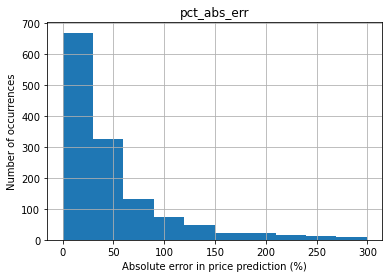

In [97]:
df_err_knn = df_pct_abs_err(y_pred_knn, y_train, plot=True)

In [98]:
df_err_knn['pct_abs_err'].median()

31.11308683976694

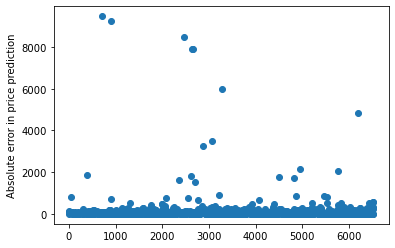

In [99]:
plt.plot(np.abs(y_train - y_pred_knn), 'o')
plt.ylabel('Absolute error in price prediction')
plt.show()

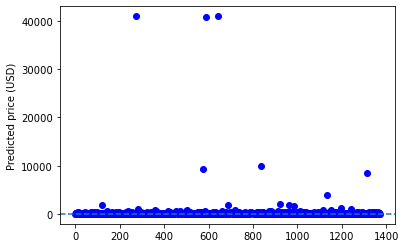

In [100]:
plt.plot(y_train_knn, 'bo')
plt.axhline(y=0, linestyle='--')
plt.ylabel('Predicted price (USD)')
plt.show()

In [74]:
pipe, X_test_cutoff = fit_model(X_train, y_train, X_train, KNeighborsRegressor(weights='distance'), cutoff=-1)
y_pred_knn = pipe.predict(X_test_cutoff)

In [75]:
pipe.score(X_test, y_test)

0.058106125837373956

In [110]:
pipe, X_train, X_test, y_train, y_test = fit_model(X, y, KNeighborsRegressor(weights='distance'), 0)

In [111]:
pipe.score(X_test, y_test)

0.945492970822294

Much, much better!

What if I use the information I gained from the Elastic Net regression? That is, I will use the data with irrelevant features removed.

In [112]:
pipe, X_train, X_test, y_train, y_test = fit_model(X_E, y, KNeighborsRegressor(weights='distance'), 0)

In [113]:
pipe.score(X_test, y_test)

0.9454464481117824

Not much of an improvement.

In [216]:
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(weights='distance'))
cutoff = 0.001
X_cutoff = X.iloc[:, np.where((X.sum()/len(X) > cutoff) == True)[0]]
X_train, X_test, y_train, y_test = train_test_split(
    X_cutoff, y, test_size=0.3, random_state=4)
cross_val_score(pipe, X_train, y=y_train)

array([0.24357915, 0.97101526, 0.74296027, 0.98153118, 0.97929122])

In [218]:
cutoffs = [1000, 1, .99, .9, .7, .5, .3, .2, .1, .05, .01, 0.005, 0.001, 0]
test_cutoffs(X, y, KNeighborsRegressor(weights='distance'), cutoffs);

Cutoff =  1e+03, train_score =  0.979, test_score =  0.946, n_features = 4
Cutoff =  1, train_score =  1, test_score =  0.913, n_features = 37
Cutoff =  0.99, train_score =  1, test_score =  0.913, n_features = 39
Cutoff =  0.9, train_score =  1, test_score =  0.902, n_features = 46
Cutoff =  0.7, train_score =  1, test_score =  0.97, n_features = 61
Cutoff =  0.5, train_score =  1, test_score =  0.92, n_features = 69
Cutoff =  0.3, train_score =  1, test_score =  0.862, n_features = 75
Cutoff =  0.2, train_score =  1, test_score =  0.861, n_features = 78
Cutoff =  0.1, train_score =  1, test_score =  0.894, n_features = 85
Cutoff =  0.05, train_score =  1, test_score =  0.943, n_features = 98
Cutoff =  0.01, train_score =  1, test_score =  0.93, n_features = 164
Cutoff =  0.005, train_score =  1, test_score =  0.826, n_features = 202
Cutoff =  0.001, train_score =  1, test_score =  0.833, n_features = 307
Cutoff =  0, train_score =  1, test_score =  0.833, n_features = 739


In [114]:
y_pred_knn = pipe.predict(X_test)

In [116]:
u = ((y_test - y_pred_knn)**2).sum()
v = ((y_test - y_test.mean())**2).sum()
1 - u/v

0.9454464481117824

In [123]:
y_pred_knn[100]

95.8132806775484

In [122]:
list(y_test)[100]

73.0

In [119]:
np.mean(np.abs((y_pred_knn - y_test)))

95.5514158090241

In [125]:
np.mean(np.abs((y_pred_knn - y_test)/y_test))

0.6417666462579966

Intuitively speaking, this is still quite far from a good predictor. On average, it's off from the true values by about $100, or 64%.

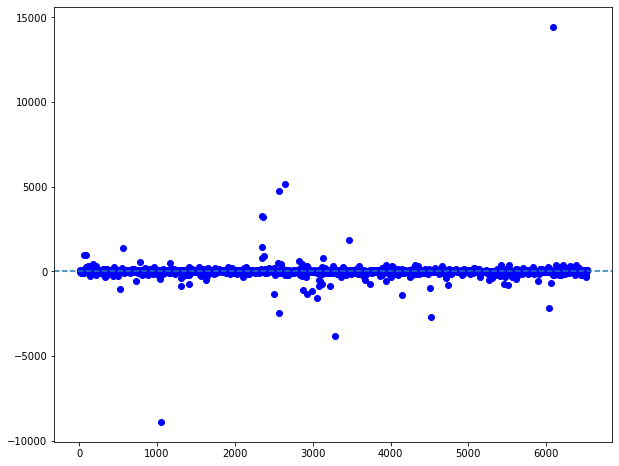

In [126]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_knn - y_test, 'bo')
plt.axhline(y=0, linestyle='--')
#plt.ylim(-200, 200)
plt.show()

In [229]:
listings.loc[1049].head(20)

id                                                                15287352
listing_url                          https://www.airbnb.com/rooms/15287352
scrape_id                                                   20211018161857
last_scraped                                                    2021-10-18
name                                     Wrigleyville Mansion - Sleeps 16+
description              Wrigleyville Mansion is the perfect place to h...
neighborhood_overview    - Wrigley Field<br />- Southport Corridor<br /...
picture_url              https://a0.muscache.com/pictures/dc2c60b9-14f0...
host_id                                                           45401863
host_url                        https://www.airbnb.com/users/show/45401863
host_name                                                              Joe
host_since                                                      2015-09-29
host_location                             Chicago, Illinois, United States
host_about               

In [230]:
y_train.sort_values(ascending=False)[:20]

2341    48864.0
2648    48864.0
2647    48864.0
2361    47484.0
2360    47484.0
2362    47484.0
2346    40356.0
2345    40356.0
2650    39132.0
2350    39132.0
2354    39132.0
2353    39132.0
2358    39132.0
2357    39132.0
2351    39132.0
1049     9999.0
3289     9999.0
3288     9999.0
6196     5000.0
2866     3690.0
Name: price, dtype: float64

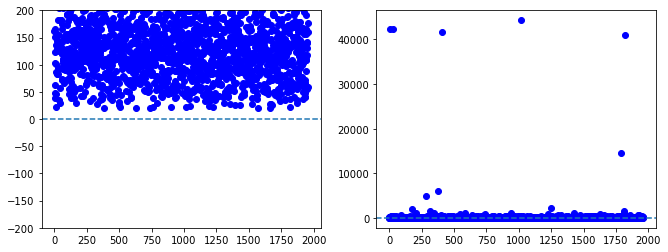

In [136]:
fig, ax = plt.subplots(ncols=2, figsize=(11,4))
ax[0].plot(y_pred_knn, 'bo')
ax[0].axhline(y=0, linestyle='--')
ax[0].set_ylim(-200, 200)
ax[1].plot(y_pred_knn, 'bo')
ax[1].axhline(y=0, linestyle='--')
plt.show()

This is at least good - none of the price predictions on the test set are negative.

### Random Forest

In [137]:
from sklearn.ensemble import RandomForestRegressor

In [157]:
pipe, X_train, X_test, y_train, y_test = fit_model(X, y, RandomForestRegressor(random_state=1), 0)

In [158]:
pipe.score(X_test, y_test)

0.9141108633452861

In [180]:
pipe, X_train, X_test, y_train, y_test = fit_model(X_E, y, RandomForestRegressor(n_estimators=1000,random_state=1), 0)

In [181]:
pipe.score(X_test, y_test)

0.9206594768060465

This is a bit worse than the k-nearest neighbors model! I tried several values of `random_state` and never got anything better than the k-nearest neighbors model.

In [162]:
y_pred_RF = pipe.predict(X_test)

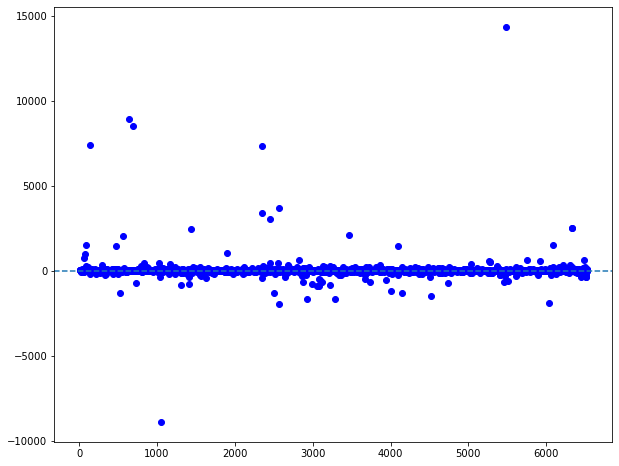

In [163]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_RF - y_test, 'bo')
plt.axhline(y=0, linestyle='--')
#plt.ylim(-200, 200)
plt.show()

### Gradient Boosting

### Neural Network (MLP)

Finally, I'll try using a simple neural network model: just a multi-layer perceptron (MLP) without bells and whistles.

In [182]:
from sklearn.neural_network import MLPRegressor

In [185]:
pipe, X_train, X_test, y_train, y_test = fit_model(
    X_E, y, MLPRegressor(random_state=1, max_iter=500), 0)

/Users/tjdauer/miniforge3/envs/myenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [187]:
pipe.score(X_test, y_test)

0.5479664967336064